In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import KBinsDiscretizer
from scipy.optimize import minimize

# Load your data
df = pd.read_csv('Task 3 and 4_Loan_Data.csv')

In [3]:
fico_scores = df['fico_score'].values
defaults = df['default'].values

In [4]:
def mse_cost_function(buckets, scores, defaults):
    bucket_edges = np.sort(buckets)
    bucket_edges = np.concatenate(([min(scores)], bucket_edges, [max(scores)]))
    bucket_means = []

    for i in range(len(bucket_edges) - 1):
        in_bucket = (scores >= bucket_edges[i]) & (scores < bucket_edges[i + 1])
        bucket_means.append(np.mean(defaults[in_bucket]) if np.sum(in_bucket) > 0 else 0)

    mse = 0
    for i in range(len(bucket_edges) - 1):
        in_bucket = (scores >= bucket_edges[i]) & (scores < bucket_edges[i + 1])
        mse += np.sum((defaults[in_bucket] - bucket_means[i]) ** 2)

    return mse

In [5]:
initial_buckets = np.linspace(min(fico_scores), max(fico_scores), num=6)[1:-1]
result = minimize(mse_cost_function, initial_buckets, args=(fico_scores, defaults), bounds=[(min(fico_scores), max(fico_scores))]*len(initial_buckets))
optimal_buckets = np.sort(result.x)

In [6]:
def log_likelihood_function(buckets, scores, defaults):
    bucket_edges = np.sort(buckets)
    bucket_edges = np.concatenate(([min(scores)], bucket_edges, [max(scores)]))
    n_buckets = len(bucket_edges) - 1
    n = np.zeros(n_buckets)
    k = np.zeros(n_buckets)

    for i in range(n_buckets):
        in_bucket = (scores >= bucket_edges[i]) & (scores < bucket_edges[i + 1])
        n[i] = np.sum(in_bucket)
        k[i] = np.sum(defaults[in_bucket])

    p = k / n
    log_likelihood = np.sum(k * np.log(p + 1e-10) + (n - k) * np.log(1 - p + 1e-10))

    return -log_likelihood 

In [7]:
initial_buckets = np.linspace(min(fico_scores), max(fico_scores), num=6)[1:-1]
result = minimize(log_likelihood_function, initial_buckets, args=(fico_scores, defaults), bounds=[(min(fico_scores), max(fico_scores))]*len(initial_buckets))
optimal_buckets_ll = np.sort(result.x)

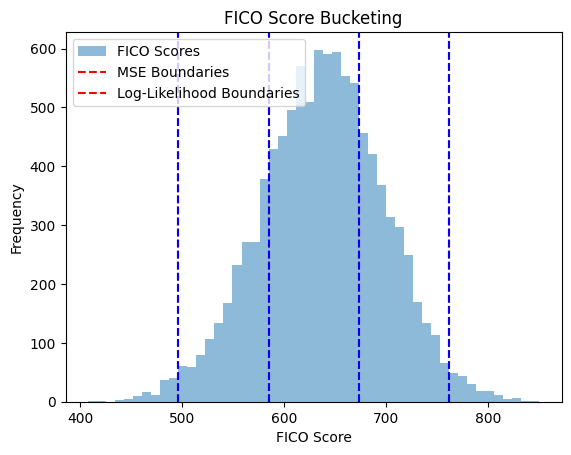

In [8]:
import matplotlib.pyplot as plt

plt.hist(fico_scores, bins=50, alpha=0.5, label='FICO Scores')
for edge in optimal_buckets:
    plt.axvline(x=edge, color='r', linestyle='--')
for edge in optimal_buckets_ll:
    plt.axvline(x=edge, color='b', linestyle='--')

plt.legend(['FICO Scores', 'MSE Boundaries', 'Log-Likelihood Boundaries'])
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.title('FICO Score Bucketing')
plt.show()